<a href="https://colab.research.google.com/github/SayantikaSaha9/LSTMPasswordStrength/blob/main/LSTMPasswordStrength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import sklearn
from sklearn.model_selection import train_test_split
import warnings
import os
warnings.filterwarnings("ignore")

In [ ]:
conn = sqlite3.connect("password_data.sqlite")
df = pd.read_sql_query("SELECT * FROM Users", conn)
conn.close()

In [ ]:
#Dataset Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     100000 non-null  int64 
 1   password  100000 non-null  object
 2   strength  100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [ ]:
#Column Names
df.columns

Index(['index', 'password', 'strength'], dtype='object')

In [ ]:
#Missing Values Per Column
df.isnull().sum()

,0
index,0
password,0
strength,0


In [ ]:
#Duplicate Rows Count
df.duplicated().sum()

0

In [ ]:
#Basic Statistics
df.describe(include='all')

,index,password,strength
count,100000.000000,100000,100000.000000
unique,NaN,100000,NaN
top,NaN,zxe870819,NaN
freq,NaN,1,NaN
mean,49999.500000,NaN,0.988730
std,28867.657797,NaN,0.510926
min,0.000000,NaN,0.000000
25%,24999.750000,NaN,1.000000
50%,49999.500000,NaN,1.000000
75%,74999.250000,NaN,1.000000


In [ ]:
#Class Distribution
df['strength'].value_counts()

,count
strength,
1,73883
0,13622
2,12495


In [ ]:
#Most Common Characters in Weak Passwords
weak_chars = ''.join(df[df['strength'] == 0]['password'])
pd.Series(list(weak_chars)).value_counts().head(10)

,count
a,6975
1,5420
e,4767
o,4332
i,4002
s,3257
n,3235
r,3211
2,3178
0,2907


In [ ]:
#Most Common Characters in Strong Passwords
strong_chars = ''.join(df[df['strength'] == 2]['password'])
pd.Series(list(strong_chars)).value_counts().head(10)

,count
M,5703
A,5621
a,5590
1,5349
N,4892
Q,4765
g,4704
0,4695
2,4652
e,4425


In [ ]:
#Outlier Detection, i.e, passwords which are too long
Outliers = df[pd.Series(df['password'].apply(len)) > pd.Series(df['password'].apply(len)).quantile(0.99)]['password']

In [ ]:
Outliers

,password
3,accounts6000webhost.com
180,karolina.susnina0U
192,<html>13476590nosD
242,Therockrockbottom72
306,twDLi4Sd2l5ZRJZ8UEvL
...,...
99091,griboedova.natalja1X
99187,QWERKaelani04032014
99255,345e9ret_TR4eyxsPv54E_i
99661,kristina-novokshonova1S


In [ ]:
Outliers.count()

762

In [ ]:
# Drop unnecessary columns like index (if present)
df.drop(columns=['index'], errors='ignore', inplace=True)

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop rows with missing passwords
df.dropna(inplace=True)

Missing values:
 password    0
strength    0
dtype: int64


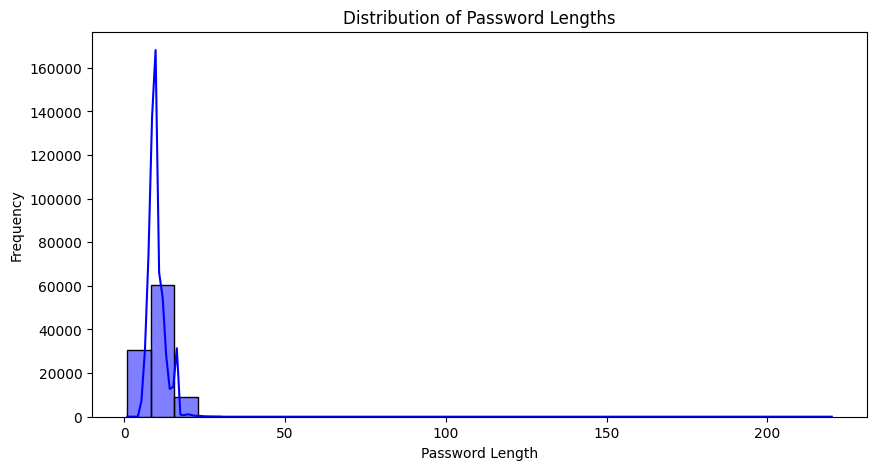

count    100000.000000
mean          9.986700
std           2.887813
min           1.000000
25%           8.000000
50%           9.000000
75%          11.000000
max         220.000000
Name: length, dtype: float64


In [ ]:
# Plot password length distribution
df['length'] = df['password'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df['length'], bins=30, kde=True, color='blue')
plt.xlabel("Password Length")
plt.ylabel("Frequency")
plt.title("Distribution of Password Lengths")
plt.show()

# Print basic stats
print(df['length'].describe())

In [ ]:
# Find the optimal sequence length (excluding extreme outliers)
optimal_length = int(np.percentile(df['length'], 95))

print(f"Optimal Sequence Length: {optimal_length}")

Optimal Sequence Length: 16


In [ ]:
# Tokenize passwords at character level
tokenizer = Tokenizer(char_level=True, filters="", oov_token="<OOV>")
tokenizer.fit_on_texts(df['password'])

# Convert passwords into sequences of numbers
password_sequences = tokenizer.texts_to_sequences(df['password'])

# Apply padding using the optimal length
X_padded = pad_sequences(password_sequences, maxlen=optimal_length, padding='pre', truncating='pre')

# Extract labels
y = df['strength'].values  # 0 = Weak, 1 = Medium, 2 = Strong

In [ ]:
#splitting of ds
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Define the LSTM model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=64,
                    input_length=optimal_length))

# BiLSTM Layer
model.add(Bidirectional(LSTM(units=128, return_sequences=False, dropout=0.3)))

# Fully Connected Layer
model.add(Dense(units=3, activation='softmax'))

# Compile the Model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# **Fix: Build the model before summary**
model.build(input_shape=(None, optimal_length))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 16, 64)              │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,867 (800.26 KB)

 Trainable params: 204,867 (800.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=16,
                    validation_data=(X_test, y_test))

Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 131s 25ms/step - accuracy: 0.9843 - loss: 0.0474 - val_accuracy: 1.0000 - val_loss: 7.9261e-05
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 142s 25ms/step - accuracy: 0.9998 - loss: 7.4653e-04 - val_accuracy: 1.0000 - val_loss: 2.0355e-04
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - accuracy: 1.0000 - loss: 1.1828e-04 - val_accuracy: 1.0000 - val_loss: 3.2898e-06
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 141s 25ms/step - accuracy: 1.0000 - loss: 2.0319e-06 - val_accuracy: 1.0000 - val_loss: 6.8146e-08
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 123s 25ms/step - accuracy: 1.0000 - loss: 7.8058e-08 - val_accuracy: 1.0000 - val_loss: 4.6790e-09
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 144s 25ms/step - accuracy: 1.0000 - loss: 5.0402e-09 - val_accuracy: 1.0000 - val_loss: 6.5565e-11
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 143s 25ms/step - accuracy: 1.0000 - loss: 4.9026e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
5000/5

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 1.0000 - loss: 4.1339e-06
Test Accuracy: 1.0000


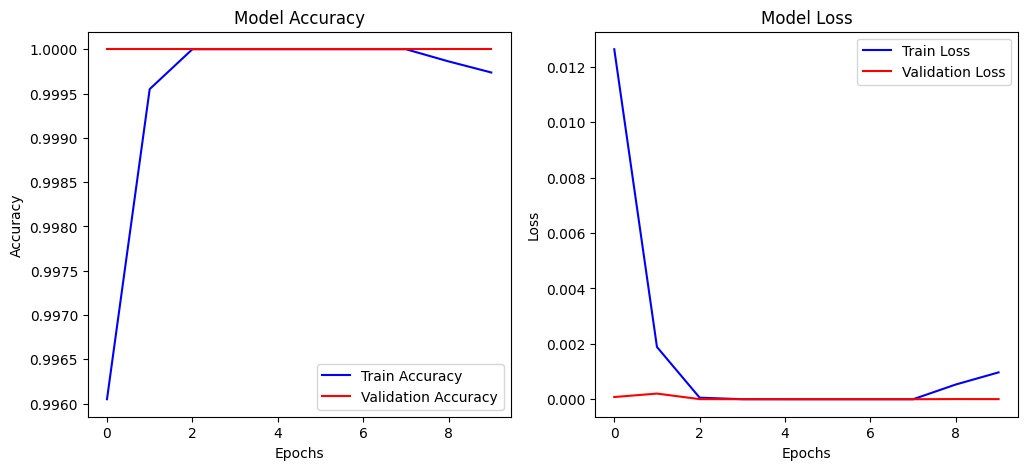

In [ ]:
#plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()


In [ ]:
#testing it on new passwords
def predict_password_strength(password):
    """Predicts the strength of a given password."""
    sequence = tokenizer.texts_to_sequences([password])
    padded = pad_sequences(sequence, maxlen=optimal_length, padding='post')

    prediction = model.predict(padded)
    strength = np.argmax(prediction)

    labels = {0: "Weak", 1: "Medium", 2: "Strong"}
    return labels[strength]

In [ ]:
predict_password_strength(password="$ob#dgaytdlff90@1999")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


'Strong'